In [233]:
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    plot_confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Data Collection

Im Folgenden Schritt werden die Daten aus den vorgegebenen Verzeichnissen eingelesen. Sofern Ordner nicht bestehen, wird eine Fehlermeldung ausgegeben.

In [234]:

# Color Map für Charts
cmap = cm.get_cmap("Blues")

dir_data = './data/'

# Bereitgestellte Dateien
filename_train_values = 'train_values.csv'
filename_train_labels = 'train_labels.csv'
filename_prediction_values = 'test_values.csv'

# Erzeuge Dateinamen für gegebene Datein
filepath_train_values = os.path.join(dir_data, filename_train_values)
filepath_train_labels = os.path.join(dir_data, filename_train_labels)
filepath_prediction_values = os.path.join(dir_data, filename_prediction_values)

# Erzeugte Dateipfad für zu erzeugende Dateien
filename_prediction_labels = 'BILZ_MARKUS_prediction.csv'
filepath_prediction_labels = os.path.join(dir_data, filename_prediction_labels)

# Prüfungen auf Vorhandensein Daten
if not os.path.isdir(dir_data):
    raise FileNotFoundError("Data Verzeichnis fehlend.")
if not len(os.listdir(dir_data)):
    raise FileNotFoundError("Dateien fehlend.")

if not filepath_train_values:
    raise FileNotFoundError(f"{filename_train_values} fehlend.")
if not filepath_train_labels:
    raise FileNotFoundError(f"{filename_train_labels} fehlend.")
if not filepath_prediction_values:
    raise FileNotFoundError(f"{filename_prediction_values} fehlend.")

# Lade gegebene Daten in Pandas DataFrame ein.
train_values = pd.read_csv(filepath_train_values, sep='|')
train_labels = pd.read_csv(filepath_train_labels, sep='|')
test_values = pd.read_csv(filepath_prediction_values, sep='|')

## Explore Data

Für die eingelesenen Dateien liegen Metadaten vor. Diese lautet wiefolgt:

1. $tau[x]$: reaction time of participant (real from the range $[0.5,10]$s). Tau1 - the value for electricity producer.
2. $p[x]$: nominal power consumed(negative)/produced(positive)(real). For consumers from the range $[-0.5,-2]s^{-2}$; $p1 = |p2 + p3 + p4|$
3. $g[x]$: coefficient (gamma) proportional to price elasticity (real from the range $[0.05,1]s^{-1}$). g1 - the value for electricity producer.
4. stab: (...)
5. stabf: the stability label of the system (categorical: stable/unstable)

(Quelle: https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simul)

In [235]:
train_values.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923


In [236]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    8000 non-null   float64
 1   tau2    8000 non-null   float64
 2   tau3    8000 non-null   float64
 3   tau4    8000 non-null   float64
 4   p1      8000 non-null   float64
 5   p2      8000 non-null   float64
 6   p3      8000 non-null   float64
 7   p4      8000 non-null   float64
 8   g1      8000 non-null   float64
 9   g2      8000 non-null   float64
 10  g3      8000 non-null   float64
 11  g4      8000 non-null   float64
dtypes: float64(12)
memory usage: 750.1 KB


Automatisch zugewiesene Datentypen sind in Ordnung. Kein weiterer Handlungsbedarf im Data Cleaning Schritt.

In [237]:
train_values.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5.235266,5.263042,5.239916,5.269278,3.749237,-1.249405,-1.250982,-1.248849,0.525875,0.526143,0.524256,0.526372
std,2.748381,2.746766,2.736026,2.750045,0.756281,0.433926,0.434521,0.434267,0.274410,0.274565,0.275187,0.273592
min,0.500793,0.501582,0.500788,0.500473,1.582590,-1.999891,-1.999715,-1.999926,0.050009,0.050053,0.050054,0.050028
25%,2.855398,2.884650,2.860061,2.893386,3.212721,-1.627030,-1.629353,-1.625261,0.286748,0.285898,0.285277,0.291064
50%,5.217622,5.269852,5.253587,5.300431,3.746282,-1.250135,-1.250900,-1.245695,0.528247,0.527747,0.523578,0.526853
75%,7.608241,7.649058,7.611346,7.659247,4.285685,-0.872173,-0.869930,-0.872578,0.762899,0.764032,0.762756,0.762532
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500361,-0.500025,0.999937,0.999944,0.999839,0.999930


Mittelwert und Varianz stark unterschiedlich u. A. bei $p_1$ - $p_4$. Standardisierung notwendig im Schritt Data Cleaning. Ansonsten keine starken Ausreißer vorhanden.

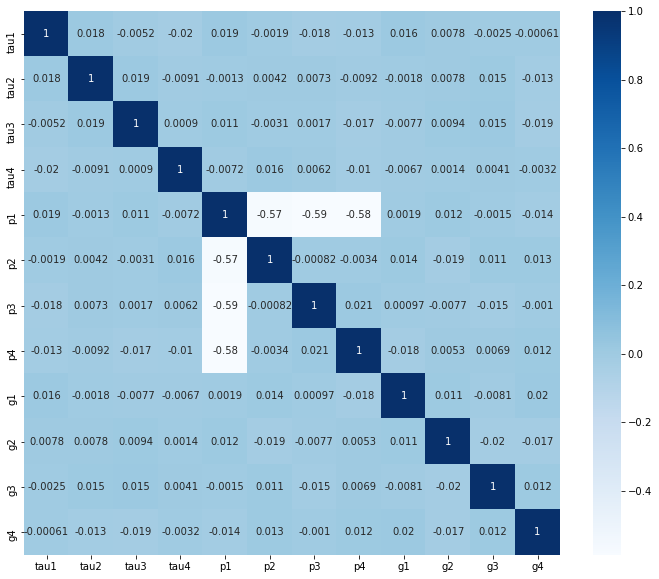

In [238]:
corr = train_values.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap=cmap)

Negative Korrelation zwischen $p_1$ - $p_4$ vorhanden. Weitere ausgeprägte Korrelation sind nicht erkennbar. 

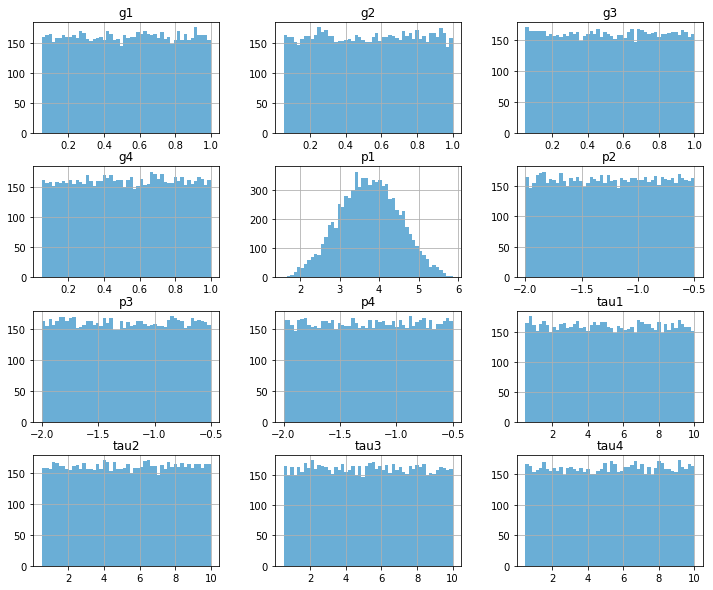

In [239]:
train_values.hist(figsize=(12,10), bins=50, color=cmap(0.5));

Alle Features (außer $p_1$) sind etwa gleichverteilt. Keine starken Ausreißer vorhanden, die behandelt werden müssten.

In [240]:
train_values.isna().sum()

tau1    0
tau2    0
tau3    0
tau4    0
p1      0
p2      0
p3      0
p4      0
g1      0
g2      0
g3      0
g4      0
dtype: int64

Keine fehlenden Daten vorhanden. Kein weiterer Handlungsbedarf im Schritt Data Cleaning.

In [241]:
train_labels.head()

,target
0,unstable
1,stable
2,unstable
3,unstable
4,unstable


## Data Preparation

In [242]:
train_values.drop(columns=['p1'])

,tau1,tau2,tau3,tau4,p2,p3,p4,g1,g2,g3,g4
0,2.959060,3.079885,8.381025,9.780754,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034
1,9.304097,4.902524,3.047541,1.369357,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760
2,8.971707,8.848428,3.046479,1.214518,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853
3,0.716415,7.669600,4.486641,2.340563,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718
4,3.134112,7.608772,4.943759,9.857573,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923
...,...,...,...,...,...,...,...,...,...,...,...
7995,3.114442,4.781072,2.427918,7.989509,-0.918191,-0.652736,-1.102228,0.867950,0.888858,0.460587,0.965026
7996,5.754191,3.032743,5.084803,4.633624,-1.717030,-1.713212,-1.769009,0.157284,0.975921,0.511555,0.696591
7997,2.042954,8.514335,8.173809,5.466635,-1.639912,-0.662469,-1.481417,0.154129,0.944486,0.053225,0.499109
7998,2.930406,9.487627,2.376523,6.187797,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385


$p_1$ entfernt, weil keine Prognosekraft (Quelle: https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simul). Außerdem ist Spalte $p_1$ redundant, weil Summe aus $p_2$ - $p_4$.

In [243]:
feature_names = train_values.columns

scaler = StandardScaler()
train_values = scaler.fit_transform(train_values)

Anwendung von `StandardScalar` um Daten zu standardisieren.

In [244]:
label_encoder = LabelEncoder()
train_labels['target'] = label_encoder.fit_transform(train_labels['target'])
train_labels.head()

,target
0,1
1,0
2,1
3,1
4,1


Anwendung des LabelEncoders, um Strings in Integer für Verwendung in Modell zu konvertieren. Bspw. wird 'unstable = 1' encodiert.

In [245]:
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels, test_size=0.3, random_state=1)

Aufteilen der Input-Daten in $70~\%$ Trainings- und $30~\%$ Testdaten

## Modeling the Data

### Baseline Model - Decision Tree

In [246]:
model_baseline = DecisionTreeClassifier(random_state=1,criterion="entropy")
model_baseline.fit(X_train, y_train)

y_pred_base = model_baseline.predict(X_test)

Baseline bildet Entscheidungsbaum mit Kriterium Entropie analog zur Vorlesung.

### Advanced Model - Teil 1: Support Vector Machine

In [247]:
model_svm = SVC(C=1.2, kernel='rbf')
model_svm.fit(X_train, y_train.values.ravel())

y_pred_svm = model_svm.predict(X_test)

print(model_svm.get_params())

{'C': 1.2, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Fraglich ist an dieser Stelle, was optimale Parameterkonfiguration für `SVC` ist. Im folgenden wird deshalb eine Gridsearch zur Ermittlung der Hyperparameter durchgeführt.

#### Tunen der Hypermeter

Grundsätzlich wäre es sinnvoll möglichst viele Hyperparameter z. B. Kernel, Regularization parameter etc. zu variieren. Da mir die Rechenressourcen dafür etwas fehlen, habe ich mich entschieden nur `Gamma` und `C` zu variieren. `C = [0 - 1.5]` In stichpunktartigen Tests habe ich herausgefunden, dass `rbf` Kernel am besten für die gegebenen Daten funktioniert, weswegen ich ihn fix vorgegeben habe. Alle übrigen Parameter entsprechen Defaultparameter. Durch den Parameter `refit` wird die Parameter bereits auf dem gesamten Datenset erneut ermittelt, womit ein nochmaliges Training auf dem gesamten Datenbestand später entfällt.

In [248]:
min_c = 0.1
step_size = 0.1
step_count = 15

C = min_c + np.arange(step_count) * step_size

param_grid = {'C': C, 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
grid_svm = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
grid_svm.fit(X_train, y_train.values.ravel())

# Bester Versuch
grid_svm_optimized = grid_svm.best_estimator_
y_pred_svm_optimized = grid_svm_optimized.predict(X_test)

print(grid_svm.best_estimator_)



SVC(C=1.5000000000000002, gamma=0.1)


### Advanced Model - Teil 2: Random Forest Classifier

In [249]:
model_rf = RandomForestClassifier(n_estimators=200)
model_rf.fit(X_train, y_train.values.ravel())
y_pred_rf = model_rf.predict(X_test)

print(model_rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Auch hier stellt sich die Frage, was optimale Parameterkonfiguration ist. Nachfolgend wird deshalb eine GridSearch durchgeführt.

#### Tunen der Hyperparameter

Wichtigster Parameter ist gem. Anwenderdoku `n_estimators`, was der Anzahl der Bäume entspricht. Variiere `n_estimators` von $10$-$500$ mit Schrittweite $10$. Weitere Parameter werden nicht variiert und bei Standardwerten belassen, um den Rechenaufwand klein zu halten. Erneut wird der Parameter `refit` aktiviert, um die besten gefunden Parameter auf dem gesamten Datenset zu verproben, was nochmaliges Training für die Prognose der Testdaten obsolet macht.

In [250]:
min_estimators = 10
max_estimators = 500

# Parameter, die variiert werden sollen.
n_estimators = [int(x) for x in np.linspace(start=min_estimators, stop=max_estimators, num=5)]
param_grid = {'n_estimators': n_estimators}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=0, refit=True)
grid_rf.fit(X_train, y_train.values.ravel())

# Bester Versuch
model_rf_optimized = grid_rf.best_estimator_
print(model_rf_optimized.get_params())

y_pred_rf_optimized = grid_rf.predict(X_test)


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 377, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Advanced Model - Teil 3: Voting Classifier (Random Forest + SVM)

Nachfolgend verbinde ich SVM und Random Forest zu Voting Classifier. Voting-Mechanismus `hard`.

In [251]:
model_voting = VotingClassifier(estimators=[('SVC', grid_svm_optimized), ('Random Forest', model_rf_optimized)],
                                   voting='hard')
model_voting.fit(X_train, y_train.values.ravel())
y_pred_voting = model_voting.predict(X_test)


## Data Evaluation

Zur Evaluation wird die Metrik der Accuracy benutzt. Weiterhin erfolgt die Erstellung der Konfusionsmatrix je Classifier. Interessehalber wird noch der Matthews Correlation Coefficient angegeben.

In [252]:
def print_result(model, y_pred_model):
    print(classification_report(y_test, y_pred_model))
    plot_confusion_matrix(model, X_test, y_test, display_labels=label_encoder.classes_, cmap=cmap)
    plt.show()
    print(f"MCC: {matthews_corrcoef(y_test, y_pred_model):.2f}")


### Baseline Model - Decision Tree

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       886
           1       0.87      0.89      0.88      1514

    accuracy                           0.85      2400
   macro avg       0.84      0.84      0.84      2400
weighted avg       0.85      0.85      0.85      2400



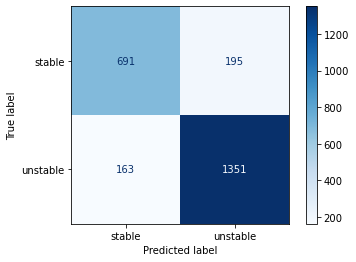

MCC: 0.68


In [253]:
print_result(model_baseline, y_pred_base)

Im Vergleich zu komplexeren Modellen erreicht der Entscheidungsbaum nur eine Accuracy von $85~\%$. Der Entscheidungsbaum ist eine gute Baseline, sollte aber ansonsten nicht weiter verwendet werden, wegen der vergleichsweise geringen Prognosequalität. Das schlechtere Abschneiden des Entscheidungsbaums u. A. ggü. Random Forest ist typisch.

Der MCC von $0.68$ weißt darauf hin, dass Klassifikation besser als Zufall ist, aber eben auch nicht perfekt. Für einen perfekten Classifier müsste sie bei $1$ liegen.

### Advanced Model - Support Vector Machine (hypertuned)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       886
           1       0.96      0.97      0.97      1514

    accuracy                           0.96      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.96      0.96      0.96      2400



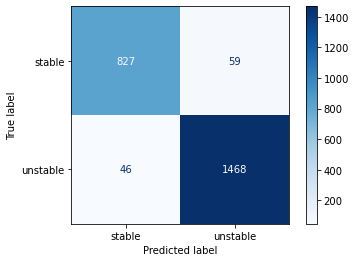

MCC: 0.91


In [254]:
print_result(grid_svm_optimized, y_pred_svm_optimized)

SVM erreicht eine sehr hohe Accuracy von $96~\%$. Die hohe Prognosequalität kann mit der vorgenommenen Grid-Search erklärt werden. Interessant wäre hier auch gewesen, mehr Kernel systematisch zu suchen.

Mit $0.91$ für MCC ist die SVM nahe dran am perfekten Classifier.

### Advanced Model - Random Forest (hypertuned)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       886
           1       0.92      0.96      0.94      1514

    accuracy                           0.92      2400
   macro avg       0.92      0.91      0.91      2400
weighted avg       0.92      0.92      0.92      2400



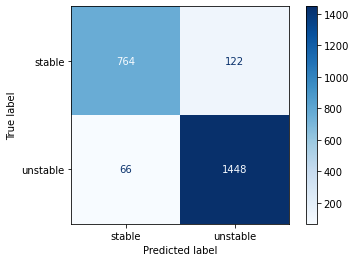

MCC: 0.83


In [255]:
print_result(model_rf_optimized, y_pred_rf_optimized)

Random Forest erreicht eine hohe Accuracy von  $92 \%$. Die hohe Prognosequalität kann mit der vorgenommenen Grid-Search erklärt werden. Dennoch ist das Ergebnis etwas schlechter als bei SVMs.

Mit $0.83$ bei MCC ist der Random Forest nahe dran am perfekten Classifier.

### Voting / Stacking (hypertuned)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       886
           1       0.98      0.94      0.96      1514

    accuracy                           0.95      2400
   macro avg       0.94      0.95      0.94      2400
weighted avg       0.95      0.95      0.95      2400



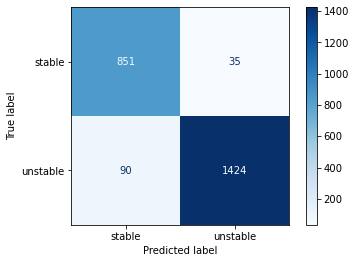

MCC: 0.89


In [256]:
print_result(model_voting, y_pred_voting)

Kombination aus Random Forest und SVM ähnlich gut wie allein SVM mit einer Accuracy von $95~\%$. Habe mich entschieden diesen Classifier auch als mein komplexes Modell zu verwenden. Zwar ist die Accuracy und der MCC etwas geringer als bei SVMs allein. Im Allgemeinen neigen Voting Classifier aber weniger zu Overfitting. Meine Erwartung ist deshalb, dass der Voting-Classifier auf ungesehenen Daten ähnlich gut / besser funktioniert als SVM allein.

### Erstellung Ausgabedatei

Zur Erzeugung der Ausgabedatei werden auf den Testdaten dieselben Datenbereinigung ausgeführt wie für die Trainingsdaten. Besonderheit ist, dass die Label mittels des `LabelEncoders` nun in Strings ausgehend von Ganzzahlen konvertiert werden. Da die Parameter bereits im Rahmen der Grid-Search auf den Gesamtbestand angepasst wurden, ist kein erneutes Training notwendig.

Konfiguration für Speichern der Datei ist zwecks Konformität zu Vorgaben nötig.

In [257]:
test_values.drop(columns=['p1'])

test_values = scaler.fit_transform(test_values)

prediction_labels = model_voting.predict(test_values)
prediction = pd.DataFrame(prediction_labels, columns=['target'])

prediction['target'] = label_encoder.inverse_transform(prediction['target'])
prediction.to_csv(filepath_prediction_labels, sep='|', index=False)

prediction.head()

,target
0,unstable
1,stable
2,unstable
3,stable
4,unstable
